<a href="https://colab.research.google.com/github/aderdouri/CQFDev/blob/master/Module_03/implicit_fdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mathematical Analysis of the Implicit Finite Difference Method

### Introduction
The Implicit Finite Difference Method is widely used for solving partial differential equations (PDEs), particularly for diffusion-type problems. Unlike explicit methods, implicit schemes are unconditionally stable for many problems, allowing for larger time steps without numerical instability.

### Derivation of the Implicit Scheme
Consider the one-dimensional heat equation:

\begin{equation}
    \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, L], \quad t > 0.
\end{equation}

Discretizing the spatial derivative using the central difference scheme:

\begin{equation}
    \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{\Delta x^2}.
\end{equation}

Using the backward Euler scheme for the time derivative:

\begin{equation}
    \frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{\Delta x^2}.
\end{equation}

Rearranging:

\begin{equation}
    u_i^{n+1} - \lambda \left( u_{i-1}^{n+1} - 2u_i^{n+1} + u_{i+1}^{n+1} \right) = u_i^n,
\end{equation}

where \( \lambda = \frac{\alpha \Delta t}{\Delta x^2} \).

This results in a tridiagonal system of equations that must be solved at each time step.

### Consistency Analysis
Using a Taylor series expansion:

\begin{align}
    u_i^{n+1} &= u_i^n + \Delta t \frac{\partial u}{\partial t} + \frac{(\Delta t)^2}{2} \frac{\partial^2 u}{\partial t^2} + O(\Delta t^3), \\
    \frac{\partial^2 u}{\partial x^2} &= \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{\Delta x^2} + O(\Delta x^2).
\end{align}

Since the PDE satisfies:

\begin{equation}
    \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2},
\end{equation}

we conclude that the implicit method is:
- **First-order accurate in time** (\( O(\Delta t) \)).
- **Second-order accurate in space** (\( O(\Delta x^2) \)).

### Stability Analysis (Von Neumann Method)
We analyze stability by considering the Fourier mode:

\begin{equation}
    u_i^n = G^n e^{j k i \Delta x}.
\end{equation}

Substituting into the finite difference equation, we get:

\begin{equation}
    G - \lambda G \left( e^{-j k \Delta x} - 2 + e^{j k \Delta x} \right) = 1.
\end{equation}

Using \( e^{j k \Delta x} + e^{-j k \Delta x} = 2 \cos(k \Delta x) \), we obtain:

\begin{equation}
    G = \frac{1}{1 + 2\lambda (1 - \cos k \Delta x)}.
\end{equation}

Since \( 1 - \cos k \Delta x \geq 0 \), we conclude that \( |G| \leq 1 \) for all \( \lambda \), proving **unconditional stability**.

### Convergence Analysis
A numerical scheme is convergent if:

\begin{equation}
    \lim_{\Delta x, \Delta t \to 0} || u^n - u_{\text{exact}}^n || = 0.
\end{equation}

By the **Lax Equivalence Theorem**, since the method is consistent (\( O(\Delta t, \Delta x^2) \)) and unconditionally stable, it follows that:

\begin{equation}
    \text{Implicit Finite Difference Method is convergent.}
\end{equation}

### Computational Aspects
- The implicit method requires solving a **tridiagonal system** at each time step.
- This can be efficiently solved in \( O(N) \) operations using the **Thomas algorithm**.
- Since it is **unconditionally stable**, larger time steps can be used.

### Conclusion
The implicit finite difference method is a powerful approach for solving diffusion-type PDEs. It provides stability advantages over explicit methods, allowing for larger time steps without instability.

Digital Call Option Price: 0.5501590692066878
Digital Put Option Price: 0.43783226535498


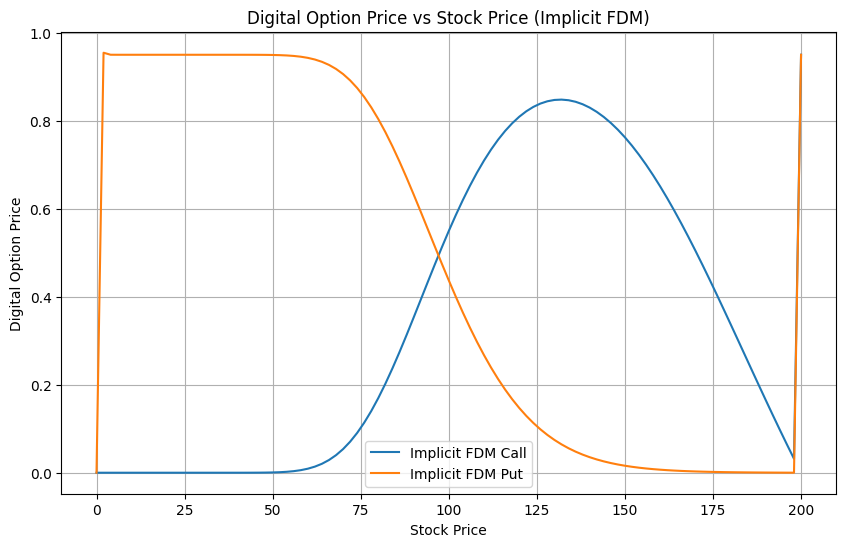

In [13]:
import numpy as np
import matplotlib.pyplot as plt

class TridiagonalSolver:
    @staticmethod
    def thomas_algorithm(a, b, c, d):
        """Solves a tridiagonal system using the Thomas Algorithm."""
        n = len(d)
        c_prime = np.zeros(n-1)
        d_prime = np.zeros(n)

        # Forward sweep
        c_prime[0] = c[0] / b[0]
        d_prime[0] = d[0] / b[0]

        for i in range(1, n-1):
            denom = b[i] - a[i-1] * c_prime[i-1]
            c_prime[i] = c[i] / denom
            d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) / denom

        d_prime[n-1] = (d[n-1] - a[n-2] * d_prime[n-2]) / (b[n-1] - a[n-2] * c_prime[n-2])

        # Backward substitution
        x = np.zeros(n)
        x[-1] = d_prime[-1]

        for i in range(n-2, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i+1]

        return x

def implicit_finite_difference(S_max, K, T, r, sigma, M, N, P=1, option_type='call'):
    """
    Corrected Implicit Finite Difference Method for Digital Option Pricing.

    Parameters:
    S_max : float  -> Maximum stock price considered
    K : float      -> Strike price
    T : float      -> Time to maturity
    r : float      -> Risk-free rate
    sigma : float  -> Volatility
    M : int        -> Number of stock price steps
    N : int        -> Number of time steps
    P : float      -> Payout of the digital option
    option_type : str -> Type of digital option ('call' for cash-or-nothing call, 'put' for cash-or-nothing put)

    Returns:
    S: Array of stock prices
    V: Digital option prices at t=0
    """
    # Grid setup
    dS = S_max / M  # Stock price step
    dt = T / N      # Time step

    S = np.linspace(0, S_max, M+1)  # Stock price grid
    V = np.zeros(M+1)               # Option price at each stock price

    # Digital option payoff
    if option_type == 'call':
        V[:] = np.where(S >= K, P, 0)
    elif option_type == 'put':
        V[:] = np.where(S <= K, P, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Coefficients for implicit method
    j = np.arange(1, M)  # Interior points
    alpha = 0.5 * dt * (sigma**2 * j**2 - r * j)
    beta = 1 + dt * (sigma**2 * j**2 + r)
    gamma = 0.5 * dt * (sigma**2 * j**2 + r * j)

    # Construct tridiagonal matrix
    a = -alpha[1:]  # Sub-diagonal
    b = beta        # Main diagonal
    c = -gamma[:-1]  # Super-diagonal

    # Time-stepping (backward in time)
    for j in range(N-1, -1, -1):
        d = V[1:M]  # Right-hand side of the equation
        V[1:M] = TridiagonalSolver.thomas_algorithm(a, b, c, d)

        # Apply boundary conditions
        V[0] = 0  # If S = 0, digital option is worthless
        V[-1] = P * np.exp(-r * (T - j * dt))  # Cash-or-nothing decay

    return S, V

# Example Parameters
S_max = 200  # Maximum stock price considered
K = 100      # Strike price
T = 1        # Time to maturity (1 year)
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
M = 100      # Number of stock price steps
N = 100      # Number of time steps

# Compute Digital Option Price using Corrected Implicit FDM for call option
S_values_implicit_call, V_values_implicit_call = implicit_finite_difference(
    S_max, K, T, r, sigma, M, N, P=1, option_type='call'
)

# Compute Digital Option Price using Corrected Implicit FDM for put option
S_values_implicit_put, V_values_implicit_put = implicit_finite_difference(
    S_max, K, T, r, sigma, M, N, P=1, option_type='put'
)

# Find the index corresponding to the initial stock price S0
index_S0_implicit_call = np.argmin(np.abs(S_values_implicit_call - K))
digital_option_price_implicit_call = V_values_implicit_call[index_S0_implicit_call]

index_S0_implicit_put = np.argmin(np.abs(S_values_implicit_put - K))
digital_option_price_implicit_put = V_values_implicit_put[index_S0_implicit_put]

print("Digital Call Option Price:", digital_option_price_implicit_call)
print("Digital Put Option Price:", digital_option_price_implicit_put)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S_values_implicit_call, V_values_implicit_call, label='Implicit FDM Call')
plt.plot(S_values_implicit_put, V_values_implicit_put, label='Implicit FDM Put')
plt.xlabel('Stock Price')
plt.ylabel('Digital Option Price')
plt.title('Digital Option Price vs Stock Price (Implicit FDM)')
plt.legend()
plt.grid(True)
plt.show()